# Imports

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as df
#from dask_ml.impute import SimpleImputer
#from dask_ml.xgboost import XGBClassifier
#from dask_ml.preprocessing import LabelEncoder
#from dask_ml.model_selection import KFold
#from dask_ml.linear_model import LogisticRegression
from dask.distributed import Client, LocalCluster
from dask import compute
from xgboost import XGBClassifier
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, precision_score, f1_score, precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import ttest_ind, ttest_rel
from collections import namedtuple
from recordtype import recordtype

sns.set(style="darkgrid")
numpy.set_printoptions(suppress=True)
#numpy.seterr(divide='ignore', invalid='ignore')

In [2]:
SEED = 0
JOBS = 10

In [5]:
cluster = LocalCluster(n_workers=JOBS)
client = Client(cluster)

# Data Exploration

In [6]:
data = df.read_csv('./data/train_transaction.csv', header=0).set_index('TransactionID')

In [5]:
data.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 393 entries, isFraud to V339
dtypes: object(14), float64(376), int64(3)

In [7]:
data['isFraud'].value_counts().compute()

0    569877
1     20663
Name: isFraud, dtype: int64

From the table we can see that we are dealing with an imbalanced dataset.

## Missing Values

In [56]:
data.loc[:, 'TransactionAmt': 'M9'].isnull().sum().compute()

TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain      94456
R_emaildomain     453249
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
D1                  1269
D2                280797
D3                262878
D4                168922
D5                309841
D6                517353
D7                551623
D8                515614
D9                515614
D10                76022
D11               279287
D12               525823


In [7]:
sample_pos = data[data['isFraud']==1]
sample_neg = data[data['isFraud']==0].sample(frac=0.05, random_state=SEED)

In [9]:
sample = df.concat([sample_pos, sample_neg]).compute()

In [ ]:
sample.to_csv('./data/sample.csv', header=True, idnex=True)

In [3]:
types = {'TransactionAmt': 'float32', 'ProductCD': 'category', 'card1': 'float32', 'card2': 'float32', 'card3': 'float32', 'card4': 'category', 'card5': 'float32', 'card6': 'category'}
types.update({f'C{i}': 'float32' for i in range(1,15)})
types.update({f'M{i}': 'category' for i in range(1,10)})
types.update({f'D{i}': 'float32' for i in range(1,16)})
types.update({'addr1': 'float32', 'addr2': 'float32', 'dist1': 'float32', 'dist2': 'float32', 'P_emaildomain': 'category', 'R_emaildomain': 'category'})
types.update({f'V{i}': 'float32' for i in range(1, 340)})

In [4]:
data = pandas.read_csv('./data/sample.csv', header=0, dtype=types).set_index('TransactionID')

In [5]:
data.drop(columns=['TransactionDT'], inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49156 entries, 2987203 to 3544102
Columns: 392 entries, isFraud to V339
dtypes: category(14), float32(377), int64(1)
memory usage: 72.1 MB


In [7]:
y = data['isFraud']
X = data.drop(columns=['isFraud'])
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,W,18268.0,583.0,150.0,visa,226.0,credit,251.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987240,37.098000,C,13413.0,103.0,185.0,visa,137.0,credit,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987243,37.098000,C,13413.0,103.0,185.0,visa,137.0,credit,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987245,37.098000,C,13413.0,103.0,185.0,visa,137.0,credit,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987288,155.520996,C,16578.0,545.0,185.0,visa,226.0,credit,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
y.value_counts()

0    28493
1    20663
Name: isFraud, dtype: int64

In [9]:
mean_imp = SimpleImputer(strategy='mean')
mode_imp = SimpleImputer(strategy='most_frequent')

In [10]:
X[['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2']] = mean_imp.fit_transform(X[['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2']])
X[['card4', 'card6', 'P_emaildomain', 'R_emaildomain']] = mode_imp.fit_transform(X[['card4', 'card6', 'P_emaildomain', 'R_emaildomain']])
X[[f'M{i}' for i in range(1,10)]] = mode_imp.fit_transform(X[[f'M{i}' for i in range(1,10)]])
X[[f'D{i}' for i in range(1,16)]] = mean_imp.fit_transform(X[[f'D{i}' for i in range(1,16)]])
X[[f'V{i}' for i in range(1,340)]] = mean_imp.fit_transform(X[[f'V{i}' for i in range(1,340)]])

In [11]:
X.isnull().sum()

TransactionAmt    0
ProductCD         0
card1             0
card2             0
card3             0
                 ..
V335              0
V336              0
V337              0
V338              0
V339              0
Length: 391, dtype: int64

## Visualization

In [12]:
X_ = X.copy()

In [13]:
X_[['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain']] = X_[['ProductCD', 'card4', 'card6', 'P_emaildomain','R_emaildomain']].apply(LabelEncoder().fit_transform)
X_[[f'M{i}' for i in range(1,10)]] = X_[[f'M{i}' for i in range(1,10)]].apply(LabelEncoder().fit_transform)

In [14]:
X_.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000000,4,18268.0,583.0,150.0,3,226.0,1,251.000000,87.000000,...,0.487176,351.63736,654.628845,487.100952,16.051428,56.046074,31.520691,42.843468,89.323906,65.180199
2987240,37.098000,0,13413.0,103.0,185.0,3,137.0,1,291.550537,86.615471,...,0.487176,351.63736,654.628845,487.100952,16.051428,56.046074,31.520691,42.843468,89.323906,65.180199
2987243,37.098000,0,13413.0,103.0,185.0,3,137.0,1,291.550537,86.615471,...,0.487176,351.63736,654.628845,487.100952,16.051428,56.046074,31.520691,42.843468,89.323906,65.180199
2987245,37.098000,0,13413.0,103.0,185.0,3,137.0,1,291.550537,86.615471,...,0.487176,351.63736,654.628845,487.100952,16.051428,56.046074,31.520691,42.843468,89.323906,65.180199
2987288,155.520996,0,16578.0,545.0,185.0,3,226.0,1,291.550537,86.615471,...,0.487176,351.63736,654.628845,487.100952,16.051428,56.046074,31.520691,42.843468,89.323906,65.180199


In [56]:
X_ = MinMaxScaler().fit_transform(X_)

In [57]:
X_ = TSNE(n_components=2, n_jobs=JOBS).fit_transform(X_)

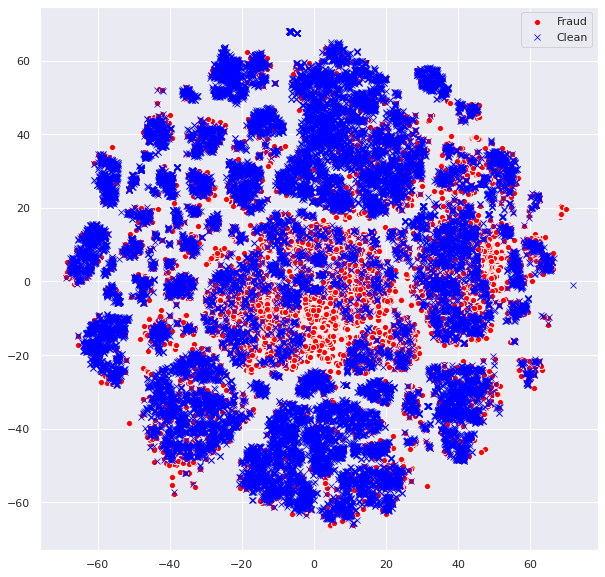

In [75]:
y_ = y.to_numpy()
plt.figure(figsize=(10,10))
sns.scatterplot(x=X_[y_==1, 0], y=X_[y_==1, 1], color='red', marker='o', label='Fraud')
sns.scatterplot(x=X_[y_==0, 0], y=X_[y_==0, 1], color='blue', marker='x', label='Clean')
plt.legend()

## Feature interaction

In [166]:
import hytests
from importlib import reload
reload(hytests)
from hytests import Hypot

In [167]:
X_ = X.copy()

In [168]:
X_[['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain']] = X_[['ProductCD', 'card4', 'card6', 'P_emaildomain','R_emaildomain']].apply(LabelEncoder().fit_transform)
X_[[f'M{i}' for i in range(1,10)]] = X_[[f'M{i}' for i in range(1,10)]].apply(LabelEncoder().fit_transform)

In [169]:
variance_filter = VarianceThreshold(threshold=0)
variance_filter.fit(X_)

VarianceThreshold(threshold=0)

In [170]:
constant_columns = [column for column in X_.columns if column not in X_.columns[variance_filter.get_support()]]
constant_columns

['M1', 'V1', 'V305']

In [171]:
tester = Hypot()

mapping = {'TransactionAmt': 'cont', 'ProductCD': 'cat', 'card1': 'cont', 'card2': 'cont', 'card3': 'cont', 'card4': 'cat', 'card5': 'cont', 'card6': 'cat'}
mapping.update({f'C{i}': 'cont' for i in range(1,15)})
mapping.update({f'M{i}': 'cat' for i in range(1,10)})
mapping.update({f'D{i}': 'cont' for i in range(1,16)})
mapping.update({'addr1': 'cont', 'addr2': 'cont', 'dist1': 'cont', 'dist2': 'cont', 'P_emaildomain': 'cat', 'R_emaildomain': 'cat'})
mapping.update({f'V{i}': 'cont' for i in range(1, 340)})

del mapping['M1']
del mapping['V1']
del mapping['V305']


In [174]:
p = tester.test(data=X_, mapping=mapping)

In [175]:
p

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,C1,C2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionAmt,1.00000,0.0,0.63840,0.00000,0.00000,0.00000,0.00005,0.00000,0.00000,0.00000,...,0.33398,0.57279,0.88054,0.90620,0.08611,0.28214,0.12987,0.00000,0.01704,0.00025
ProductCD,0.00000,1.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
card1,0.63840,0.0,1.00000,0.68847,0.00000,0.00000,0.00000,0.00000,0.60785,0.87690,...,0.00000,0.00000,0.00000,0.00000,0.43209,0.46166,0.90988,0.00002,0.00000,0.00000
card2,0.00000,0.0,0.68847,1.00000,0.00000,0.00000,0.00000,0.00000,0.30633,0.25074,...,0.00012,0.00027,0.00028,0.00012,0.53792,0.40178,0.41361,0.00023,0.00002,0.00001
card3,0.00000,0.0,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.84883,0.96029,0.96205,0.96566,0.99814,0.96606,0.97284,0.60800,0.84348,0.73546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V335,0.28214,0.0,0.46166,0.40178,0.96606,0.00000,0.00000,0.01277,0.69363,0.68787,...,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000
V336,0.12987,0.0,0.90988,0.41361,0.97284,0.00000,0.00004,0.23398,0.79025,0.79509,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
V337,0.00000,0.0,0.00002,0.00023,0.60800,0.02141,0.00000,0.02395,0.63033,0.68326,...,0.00000,0.00000,0.00000,0.00000,0.10001,0.00000,0.00000,1.00000,0.00000,0.00000
V338,0.01704,0.0,0.00000,0.00002,0.84348,0.00000,0.00000,0.00000,0.76581,0.71693,...,0.00000,0.00000,0.00000,0.00000,0.01857,0.00000,0.00000,0.00000,1.00000,0.00000


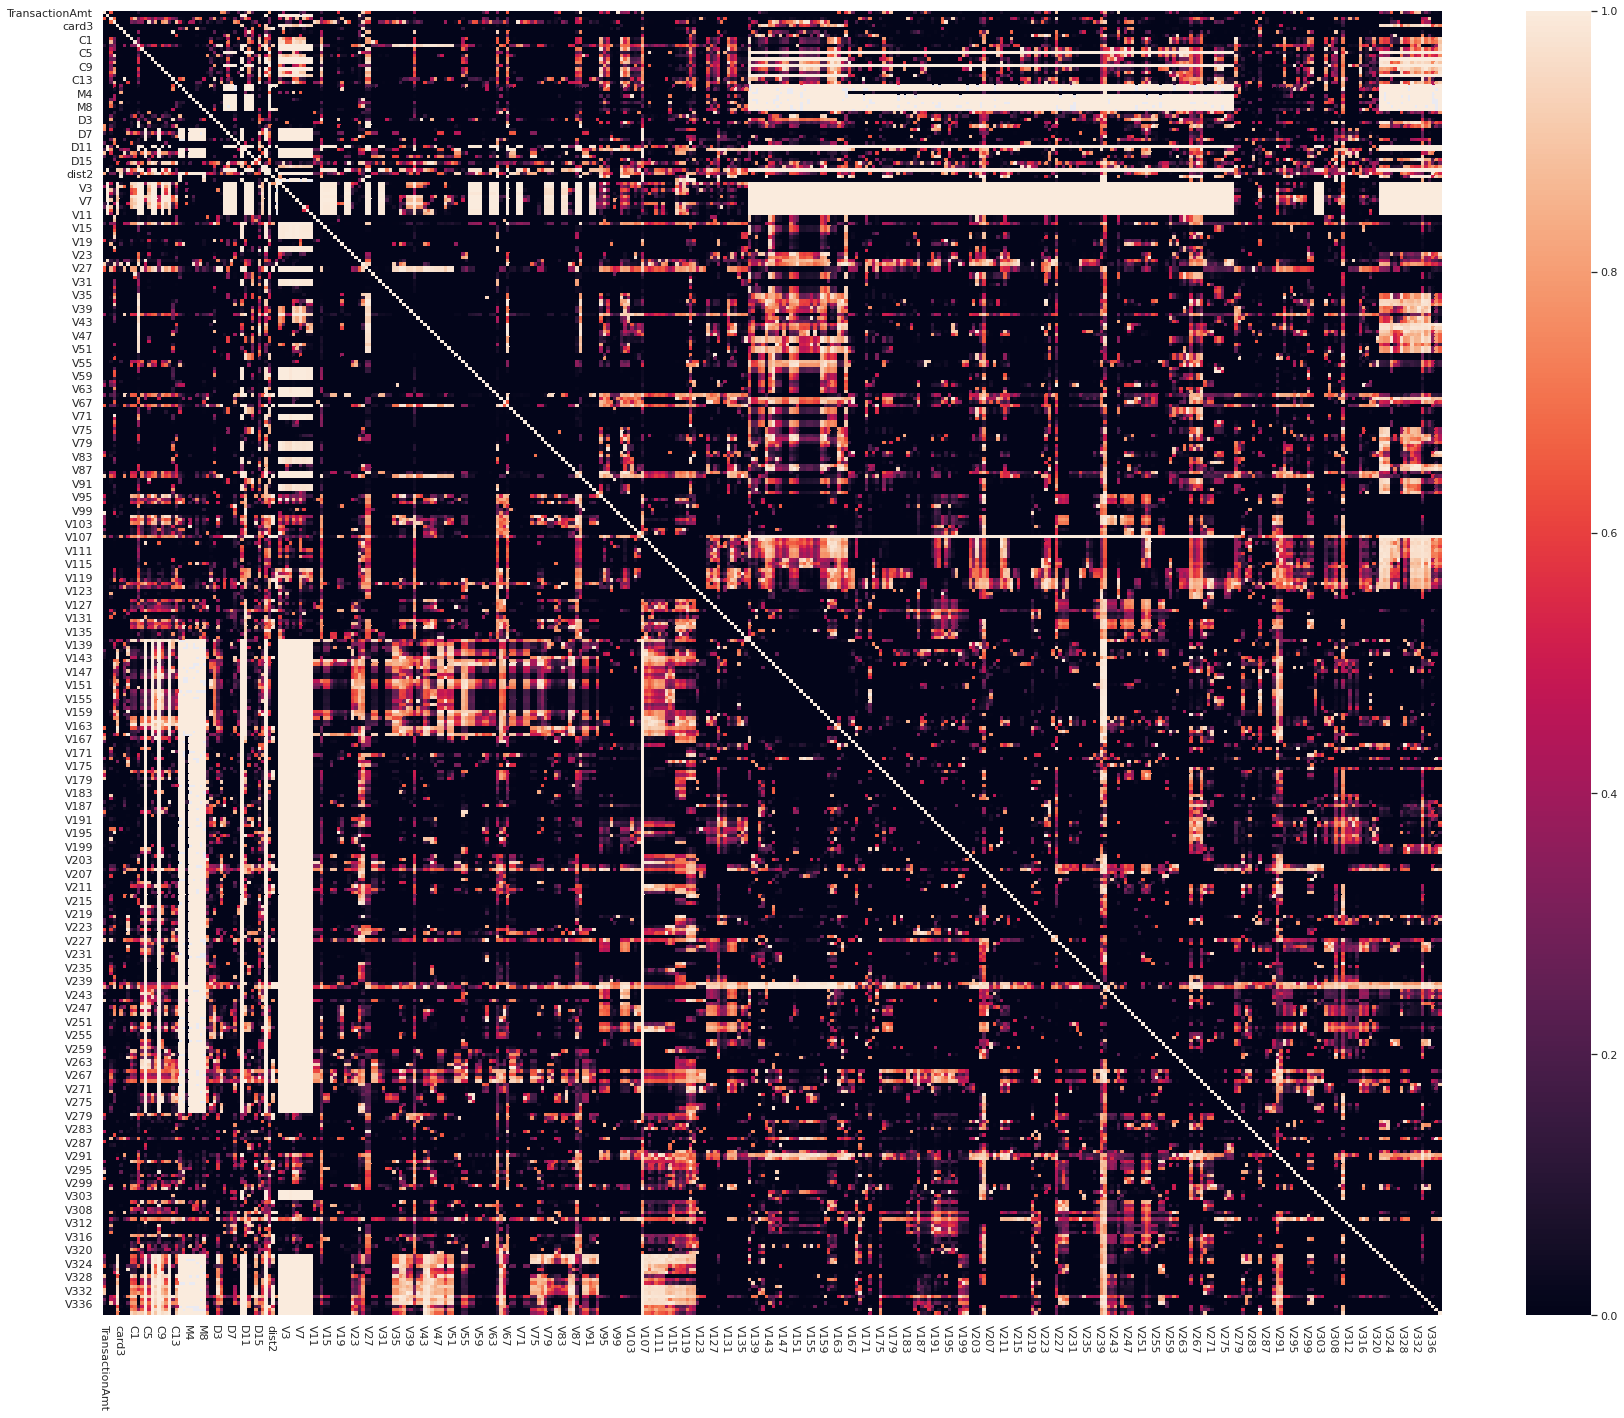

In [185]:
plt.figure(figsize=(30,24))
sns.heatmap(data=p, vmin=0, vmax=1)
plt.yticks(rotation=0)
plt.xticks(rotation=270)
plt.show()

# Modeling

## Base Dataset

In [41]:
X_base = X.copy()

In [42]:
X_base = X_base[['TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'ProductCD', 'card4', 'card6']]

In [44]:
X_p = X_base[y==1]
X_n = X_base[y==0]

<AxesSubplot:xlabel='card6', ylabel='count'>

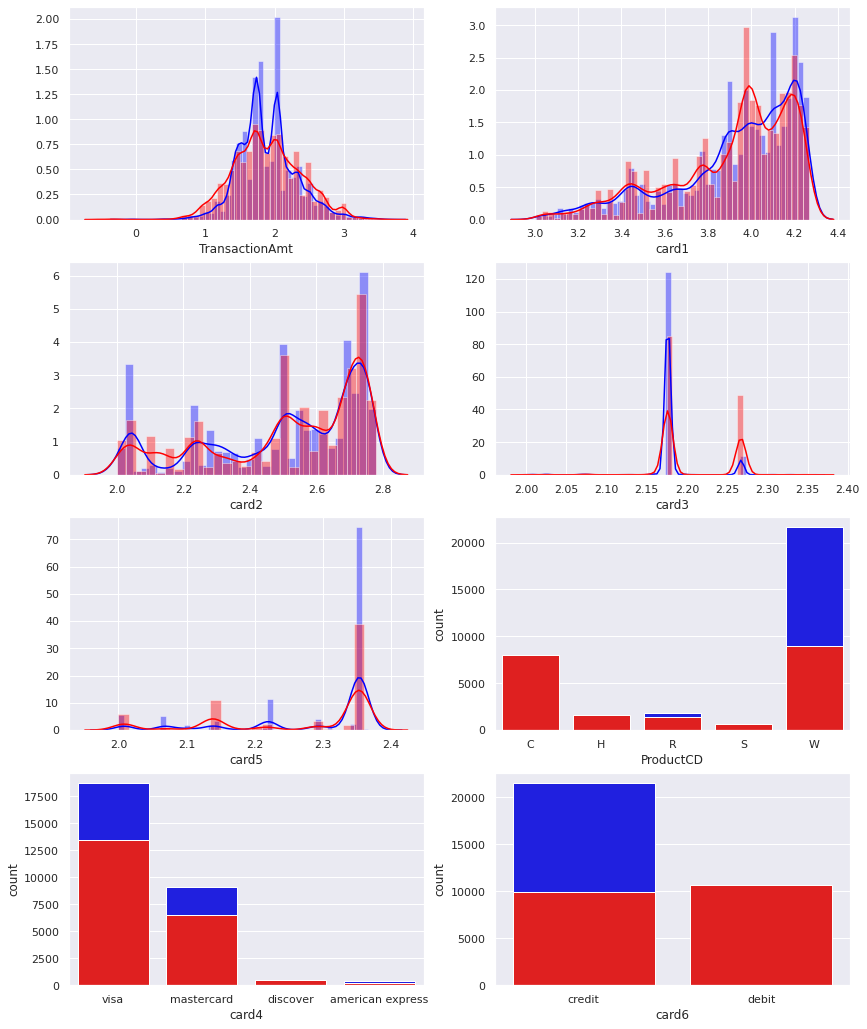

In [45]:
f, ax = plt.subplots(nrows=4, ncols=2, figsize=(14,18))
sns.distplot(a=numpy.log10(X_n['TransactionAmt']), ax=ax[0,0], color='blue')
sns.distplot(a=numpy.log10(X_p['TransactionAmt']), ax=ax[0,0], color='red')
sns.distplot(a=numpy.log10(X_n['card1']), ax=ax[0,1], color='blue')
sns.distplot(a=numpy.log10(X_p['card1']), ax=ax[0,1], color='red')
sns.distplot(a=numpy.log10(X_n['card2']), ax=ax[1,0], color='blue')
sns.distplot(a=numpy.log10(X_p['card2']), ax=ax[1,0], color='red')
sns.distplot(a=numpy.log10(X_n['card3']), ax=ax[1,1], color='blue')
sns.distplot(a=numpy.log10(X_p['card3']), ax=ax[1,1], color='red')
sns.distplot(a=numpy.log10(X_n['card5']), ax=ax[2,0], color='blue')
sns.distplot(a=numpy.log10(X_p['card5']), ax=ax[2,0], color='red')
sns.countplot(x='ProductCD', data=X_n, ax=ax[2,1], color='blue')
sns.countplot(x='ProductCD', data=X_p, ax=ax[2,1], color='red')
sns.countplot(x='card4', data=X_n, ax=ax[3,0], color='blue')
sns.countplot(x='card4', data=X_p, ax=ax[3,0], color='red')
sns.countplot(x='card6', data=X_n, ax=ax[3,1], color='blue')
sns.countplot(x='card6', data=X_p, ax=ax[3,1], color='red')

## Baseline Model

In [52]:
X_ = pandas.get_dummies(X_base, columns=['card4', 'card6', 'ProductCD'], drop_first=True)

In [53]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,card4_discover,card4_mastercard,card4_visa,card6_credit,card6_debit,card6_debit or credit,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
TransactionID,,,,,,,,,,,,,,,
2987203,445.000000,18268.0,583.0,150.0,226.0,0,0,1,1,0,0,0,0,0,1
2987240,37.098000,13413.0,103.0,185.0,137.0,0,0,1,1,0,0,0,0,0,0
2987243,37.098000,13413.0,103.0,185.0,137.0,0,0,1,1,0,0,0,0,0,0
2987245,37.098000,13413.0,103.0,185.0,137.0,0,0,1,1,0,0,0,0,0,0
2987288,155.520996,16578.0,545.0,185.0,226.0,0,0,1,1,0,0,0,0,0,0


In [54]:
X_[['TransactionAmt','card1', 'card2', 'card3', 'card5']] = numpy.log10(X_[['TransactionAmt','card1', 'card2', 'card3', 'card5']]) 

In [55]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,card4_discover,card4_mastercard,card4_visa,card6_credit,card6_debit,card6_debit or credit,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
TransactionID,,,,,,,,,,,,,,,
2987203,2.648360,4.261691,2.765669,2.176091,2.354108,0,0,1,1,0,0,0,0,0,1
2987240,1.569350,4.127526,2.012837,2.267172,2.136721,0,0,1,1,0,0,0,0,0,0
2987243,1.569350,4.127526,2.012837,2.267172,2.136721,0,0,1,1,0,0,0,0,0,0
2987245,1.569350,4.127526,2.012837,2.267172,2.136721,0,0,1,1,0,0,0,0,0,0
2987288,2.191789,4.219532,2.736397,2.267172,2.354108,0,0,1,1,0,0,0,0,0,0


In [56]:
def ml_pipeline(X, y, n_splits, model, polynomial=False):
    
    X = X.to_numpy()
    y = y.to_numpy().reshape(-1, )
    
    if polynomial:
        pol = PolynomialFeatures(interaction_only=True)
        X = pol.fit_transform(X)
        
    Output = recordtype('Output', ['precision', 'recall', 'f1', 'aucPR', 'aucROC','aucs'])
    output = Output(precision=0, recall=0, f1=0, aucPR=0, aucROC=0, aucs=[])
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    for train_index, test_index in cv.split(X, y):
    
        X_train, X_test, y_train, y_test = X[train_index, :], X[test_index, :], y[train_index], y[test_index]

        model.fit(X=X_train, y=y_train)
        y_pred = model.predict(X_test)
        y_probs = model.predict_proba(X_test)[:, 1]
    
        recall = recall_score(y_true=y_test, y_pred=y_pred)
        precision = precision_score(y_true=y_test, y_pred=y_pred)
        f1 = f1_score(y_true=y_test, y_pred=y_pred)
        precisions, recalls, _ = precision_recall_curve(y_true=y_test, probas_pred=y_probs)
        fpr, tpr, _ = roc_curve(y_true=y_test, y_score=y_probs)
        aucROC = roc_auc_score(y_true=y_test, y_score=y_probs)
        aucPR = auc(recalls, precisions)
        
        output.recall += recall
        output.precision += precision
        output.f1 += f1
        output.aucPR += aucPR
        output.aucROC += aucROC
        output.aucs.append(aucPR)
        
        print(f'precision: {precision:0.4f}, recall: {recall:0.4f}, f1: {f1:0.4f}, aucPR: {aucPR:0.4f}, aucROC: {aucROC:0.4f}')
    
    output.recall /= n_splits
    output.precision /= n_splits
    output.f1 /= n_splits
    output.aucPR /= n_splits
    output.aucROC /= n_splits
    
    print(f'Final - precision: {output.precision:0.4f}, recall: {output.recall:0.4f}, f1: {output.f1:0.4f}, aucPR: {output.aucPR:0.4f}, aucROC: {output.aucROC:0.4f}')
    
    return output

In [57]:
model = LogisticRegression(random_state=SEED, n_jobs=JOBS)
lr_base = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.6978, recall: 0.5283, f1: 0.6013, aucPR: 0.6785, aucROC: 0.7432
precision: 0.6855, recall: 0.5399, f1: 0.6041, aucPR: 0.6762, aucROC: 0.7383
precision: 0.6848, recall: 0.5530, f1: 0.6119, aucPR: 0.6817, aucROC: 0.7463
precision: 0.6777, recall: 0.5474, f1: 0.6056, aucPR: 0.6748, aucROC: 0.7477
precision: 0.6675, recall: 0.5295, f1: 0.5906, aucPR: 0.6785, aucROC: 0.7426
precision: 0.6784, recall: 0.5227, f1: 0.5905, aucPR: 0.6829, aucROC: 0.7372
precision: 0.6887, recall: 0.5610, f1: 0.6183, aucPR: 0.6867, aucROC: 0.7527
precision: 0.6794, recall: 0.5426, f1: 0.6033, aucPR: 0.6846, aucROC: 0.7461
precision: 0.6954, recall: 0.5315, f1: 0.6025, aucPR: 0.6863, aucROC: 0.7433
precision: 0.6686, recall: 0.5116, f1: 0.5797, aucPR: 0.6651, aucROC: 0.7344
Final - precision: 0.6824, recall: 0.5368, f1: 0.6008, aucPR: 0.6795, aucROC: 0.7432


## XGBoost

In [58]:
X_ = X_base.copy()

In [59]:
X_[['TransactionAmt', 'card1', 'card2', 'card3', 'card5']] = numpy.log10(X_[['TransactionAmt', 'card1', 'card2', 'card3', 'card5']])
X_[['card4', 'card6', 'ProductCD']] = X_[['card4', 'card6', 'ProductCD']].apply(LabelEncoder().fit_transform)

In [60]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output = model.fit(X_, y)

In [61]:
scores = output.get_booster().get_score(importance_type="gain")

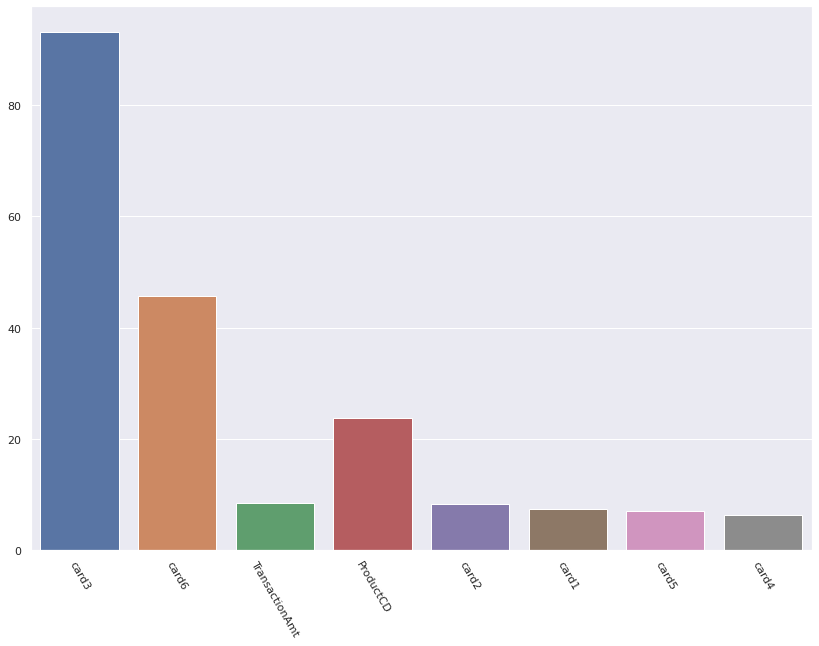

In [62]:
plt.figure(figsize=(14,10))
sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.xticks(rotation=300)
plt.show()

In [63]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_base = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.7686, recall: 0.6507, f1: 0.7047, aucPR: 0.7988, aucROC: 0.8472
precision: 0.7560, recall: 0.6715, f1: 0.7112, aucPR: 0.7877, aucROC: 0.8388
precision: 0.7682, recall: 0.6894, f1: 0.7267, aucPR: 0.8084, aucROC: 0.8567
precision: 0.7580, recall: 0.6791, f1: 0.7164, aucPR: 0.7989, aucROC: 0.8503
precision: 0.7606, recall: 0.6583, f1: 0.7058, aucPR: 0.7980, aucROC: 0.8471
precision: 0.7738, recall: 0.6641, f1: 0.7148, aucPR: 0.8052, aucROC: 0.8486
precision: 0.7426, recall: 0.6718, f1: 0.7055, aucPR: 0.7932, aucROC: 0.8415
precision: 0.7587, recall: 0.6772, f1: 0.7156, aucPR: 0.8087, aucROC: 0.8498
precision: 0.7635, recall: 0.6578, f1: 0.7067, aucPR: 0.8103, aucROC: 0.8520
precision: 0.7501, recall: 0.6583, f1: 0.7012, aucPR: 0.7906, aucROC: 0.8418
Final - precision: 0.7600, recall: 0.6678, f1: 0.7109, aucPR: 0.8000, aucROC: 0.8474


In [276]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_poly = ml_pipeline(X=X_, y=y, n_splits=10, model=model, polynomial=True)

precision: 0.7560, recall: 0.6730, f1: 0.7121, aucPR: 0.7999, aucROC: 0.8475
precision: 0.7539, recall: 0.6715, f1: 0.7103, aucPR: 0.7897, aucROC: 0.8428
precision: 0.7636, recall: 0.6812, f1: 0.7200, aucPR: 0.8113, aucROC: 0.8524
precision: 0.7474, recall: 0.6675, f1: 0.7052, aucPR: 0.7906, aucROC: 0.8437
precision: 0.7618, recall: 0.6810, f1: 0.7191, aucPR: 0.7934, aucROC: 0.8472
precision: 0.7531, recall: 0.6554, f1: 0.7008, aucPR: 0.7948, aucROC: 0.8411
precision: 0.7631, recall: 0.6859, f1: 0.7224, aucPR: 0.8046, aucROC: 0.8499
precision: 0.7563, recall: 0.6864, f1: 0.7196, aucPR: 0.7972, aucROC: 0.8457
precision: 0.7746, recall: 0.6820, f1: 0.7254, aucPR: 0.8176, aucROC: 0.8582
precision: 0.7742, recall: 0.6786, f1: 0.7232, aucPR: 0.8123, aucROC: 0.8600
Final - precision: 0.7604, recall: 0.6762, f1: 0.7158, aucPR: 0.8011, aucROC: 0.8489


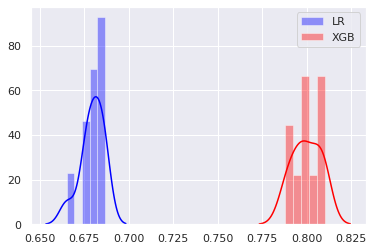

In [64]:
plt.figure()
sns.distplot(lr_base.aucs, color='blue', bins=5, label='LR')
sns.distplot(xgb_base.aucs, color='red', bins=5, label='XGB')
plt.legend()

In [66]:
ttest_rel(lr_base.aucs, xgb_base.aucs)

Ttest_relResult(statistic=-58.54539731951585, pvalue=6.2341455658683e-13)

## Feature Expansion

### C features

In [12]:
C_family = data.loc[:, 'C1':'C14']

In [13]:
C_pos = C_family.loc[y_pos.index, :]
C_neg = C_family.loc[y_neg.index, :]

In [14]:
C_p = compute(C_pos)[0]
C_n =compute(C_neg)[0]

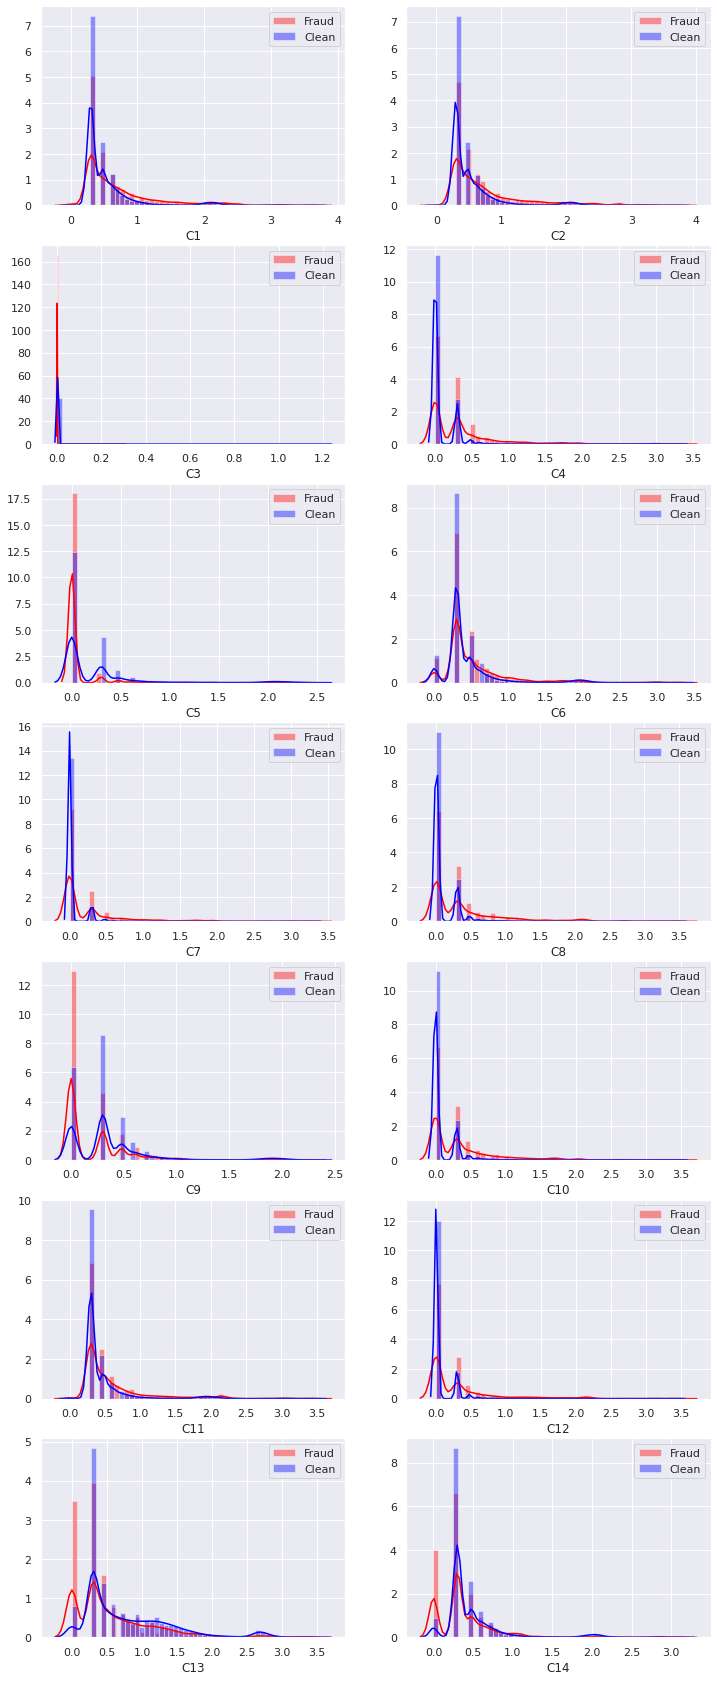

In [30]:

f, ax = plt.subplots(nrows=7, ncols=2, figsize=(12,30))

feature = 1
for row in range(0, 7):
    for col in range(0, 2):
        sns.distplot(numpy.log10(C_p[f'C{feature}'].add(1)), color='red', ax=ax[row,col], label='Fraud')
        sns.distplot(numpy.log10(C_n[f'C{feature}'].add(1)), color='blue', ax=ax[row,col], label='Clean')
        ax[row,col].legend()
        feature += 1
    

In [31]:
C = pandas.concat([C_p, C_n])

In [38]:
tester = Hypot()
mapping = {f'C{f}': 'cont' for f in range(1, 15)}

p = tester.test(data=C, mapping=mapping)

In [39]:
p

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
C1,1.00000,0.00000,0.34502,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000
C2,0.00000,1.00000,0.33016,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000
C3,0.34502,0.33016,1.00000,0.51659,0.14778,0.30963,0.54499,0.54516,0.05382,0.56924,0.3607,0.51245,0.15188,0.31487
C4,0.00000,0.00000,0.51659,1.00000,0.00038,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000
C5,0.00000,0.00000,0.14778,0.00038,1.00000,0.00000,0.00283,0.00052,0.00000,0.00108,0.0000,0.00143,0.00000,0.00000
C6,0.00000,0.00000,0.30963,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000
C7,0.00000,0.00000,0.54499,0.00000,0.00283,0.00000,1.00000,0.00000,0.00007,0.00000,0.0000,0.00000,0.00000,0.00000
C8,0.00000,0.00000,0.54516,0.00000,0.00052,0.00000,0.00000,1.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000
C9,0.00000,0.00000,0.05382,0.00000,0.00000,0.00000,0.00007,0.00000,1.00000,0.00001,0.0000,0.00002,0.00000,0.00000
C10,0.00000,0.00000,0.56924,0.00000,0.00108,0.00000,0.00000,0.00000,0.00001,1.00000,0.0000,0.00000,0.00000,0.00000


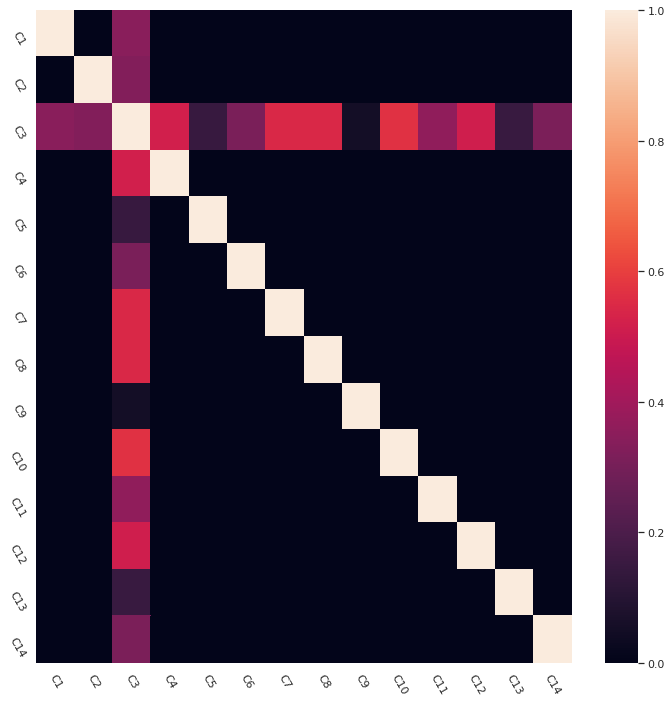

In [40]:
plt.figure(figsize=(12,12))
sns.heatmap(data=p, vmin=0, vmax=1)
plt.yticks(rotation=300)
plt.xticks(rotation=300)
plt.show()

In [93]:
XC = X.join(C, how='inner')

In [94]:
XC.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,C1,C2,...,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000,W,18268,583.0,150.0,visa,226.0,credit,2.0,2.0,...,0.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,4.0,2.0
2987240,37.098,C,13413,103.0,185.0,visa,137.0,credit,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
2987243,37.098,C,13413,103.0,185.0,visa,137.0,credit,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
2987245,37.098,C,13413,103.0,185.0,visa,137.0,credit,2.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
2987288,155.521,C,16578,545.0,185.0,visa,226.0,credit,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0


In [143]:
X_ = XC.copy()

In [144]:
X_[['TransactionAmt', 'card1', 'card2', 'card3', 'card5']] = numpy.log10(XC[['TransactionAmt', 'card1', 'card2', 'card3', 'card5']])
X_[['card4', 'card6', 'ProductCD']] = X_[['card4', 'card6', 'ProductCD']].apply(LabelEncoder().fit_transform)

In [145]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output = model.fit(X_, y)

In [146]:
scores = output.get_booster().get_score(importance_type="gain")

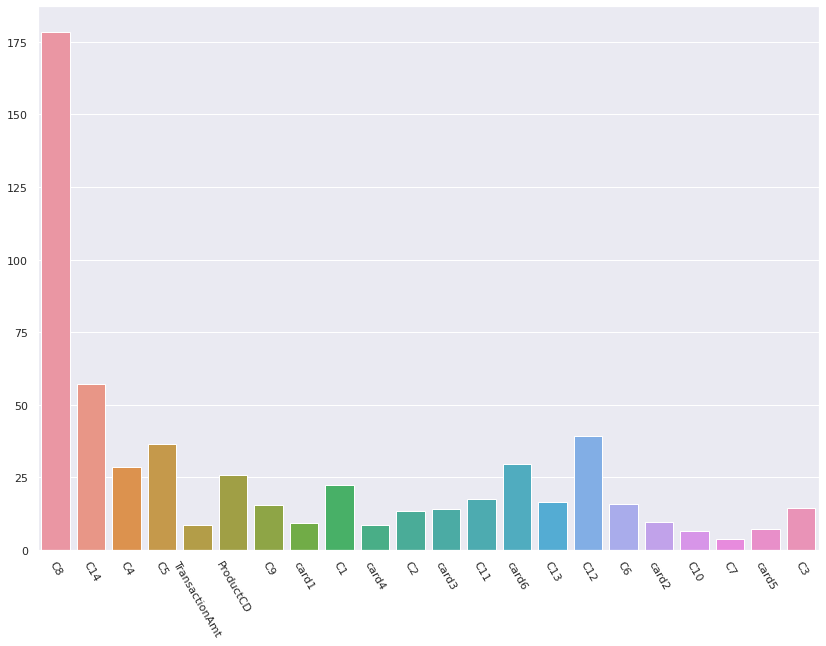

In [147]:
plt.figure(figsize=(14,10))
sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.xticks(rotation=300)
plt.show()

In [160]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,C1,C2,C3,C4,C5,...,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000,18268,583.0,150.0,226.0,2.0,2.0,0.0,0.0,0.0,...,1,0,1,0,0,0,0,0,0,1
2987240,37.098,13413,103.0,185.0,137.0,0.0,1.0,0.0,1.0,0.0,...,1,0,1,0,0,1,0,0,0,0
2987243,37.098,13413,103.0,185.0,137.0,1.0,1.0,0.0,1.0,0.0,...,1,0,1,0,0,1,0,0,0,0
2987245,37.098,13413,103.0,185.0,137.0,2.0,1.0,0.0,1.0,0.0,...,1,0,1,0,0,1,0,0,0,0
2987288,155.521,16578,545.0,185.0,226.0,1.0,1.0,0.0,1.0,0.0,...,1,0,1,0,0,1,0,0,0,0


In [163]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_c = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.8710, recall: 0.7673, f1: 0.8158, aucPR: 0.9135, aucROC: 0.9266
precision: 0.8587, recall: 0.7794, f1: 0.8171, aucPR: 0.9101, aucROC: 0.9222
precision: 0.8731, recall: 0.7857, f1: 0.8271, aucPR: 0.9232, aucROC: 0.9334
precision: 0.8731, recall: 0.7861, f1: 0.8273, aucPR: 0.9206, aucROC: 0.9339
precision: 0.8432, recall: 0.7677, f1: 0.8036, aucPR: 0.9064, aucROC: 0.9212
precision: 0.8606, recall: 0.7711, f1: 0.8134, aucPR: 0.9070, aucROC: 0.9192
precision: 0.8668, recall: 0.7657, f1: 0.8132, aucPR: 0.9132, aucROC: 0.9240
precision: 0.8756, recall: 0.7565, f1: 0.8117, aucPR: 0.9137, aucROC: 0.9267
precision: 0.8711, recall: 0.7522, f1: 0.8073, aucPR: 0.9123, aucROC: 0.9232
precision: 0.8550, recall: 0.7735, f1: 0.8122, aucPR: 0.9104, aucROC: 0.9216
Final - precision: 0.8648, recall: 0.7705, f1: 0.8149, aucPR: 0.9130, aucROC: 0.9252


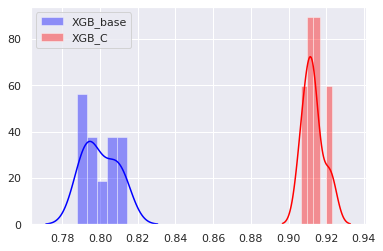

In [164]:
plt.figure()
sns.distplot(xgb_base.aucs, color='blue', bins=5, label='XGB_base')
sns.distplot(xgb_c.aucs, color='red', bins=5, label='XGB_C')
plt.legend()

In [165]:
ttest_rel(xgb_base.aucs, xgb_c.aucs)

Ttest_relResult(statistic=-40.32863418097829, pvalue=1.7641862525945233e-11)

In [72]:
C_sum = X_[[f'C{i}' for i in range(1,15)]].sum(axis=1)

In [74]:
X_['C_sum'] = C_sum
X_.drop(columns=[f'C{i}' for i in range(1,15)], inplace=True)

In [75]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,C_sum
TransactionID,,,,,,,,,,,,,,,,,,,
2987203,2.648360,4.261691,2.765669,2.176091,2.354108,0,0,0,1,0,1,0,0,0,0,0,0,1,15.0
2987240,1.569350,4.127526,2.012837,2.267172,2.136721,0,0,0,1,0,1,0,0,1,0,0,0,0,8.0
2987243,1.569350,4.127526,2.012837,2.267172,2.136721,0,0,0,1,0,1,0,0,1,0,0,0,0,9.0
2987245,1.569350,4.127526,2.012837,2.267172,2.136721,0,0,0,1,0,1,0,0,1,0,0,0,0,10.0
2987288,2.191789,4.219532,2.736397,2.267172,2.354108,0,0,0,1,0,1,0,0,1,0,0,0,0,9.0


In [76]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output_xgb = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.8091, recall: 0.6826, f1: 0.7405, aucPR: 0.8482, aucROC: 0.8806
precision: 0.7967, recall: 0.6918, f1: 0.7405, aucPR: 0.8377, aucROC: 0.8664
precision: 0.8067, recall: 0.7126, f1: 0.7567, aucPR: 0.8611, aucROC: 0.8853
precision: 0.8101, recall: 0.6936, f1: 0.7473, aucPR: 0.8562, aucROC: 0.8832
precision: 0.8034, recall: 0.6883, f1: 0.7414, aucPR: 0.8487, aucROC: 0.8749
precision: 0.8123, recall: 0.6767, f1: 0.7383, aucPR: 0.8451, aucROC: 0.8723
precision: 0.7913, recall: 0.6844, f1: 0.7340, aucPR: 0.8418, aucROC: 0.8704
precision: 0.8116, recall: 0.6883, f1: 0.7449, aucPR: 0.8541, aucROC: 0.8795
precision: 0.8081, recall: 0.6912, f1: 0.7451, aucPR: 0.8503, aucROC: 0.8782
precision: 0.7869, recall: 0.6897, f1: 0.7351, aucPR: 0.8408, aucROC: 0.8688
Final - precision: 0.8036, recall: 0.6899, f1: 0.7424, aucPR: 0.8484, aucROC: 0.8760


### Adress features

In [201]:
G_family = data.loc[:, ['addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain']]

In [202]:
G_family.head()

,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain
TransactionID,,,,,,
2987000,315.0,87.0,19.0,NaN,NaN,NaN
2987001,325.0,87.0,NaN,NaN,gmail.com,NaN
2987002,330.0,87.0,287.0,NaN,outlook.com,NaN
2987003,476.0,87.0,NaN,NaN,yahoo.com,NaN
2987004,420.0,87.0,NaN,NaN,gmail.com,NaN


In [203]:
mean_imp = SimpleImputer(strategy='mean')
mode_imp = SimpleImputer(strategy='most_frequent')

In [204]:
G_family[['addr1', 'addr2', 'dist1', 'dist2']] = mean_imp.fit_transform(G_family[['addr1', 'addr2', 'dist1', 'dist2']])
G_family[['P_emaildomain', 'R_emaildomain']] = mode_imp.fit_transform(G_family[['P_emaildomain', 'R_emaildomain']])

In [205]:
G_pos = G_family.loc[y_pos.index, :]
G_neg = G_family.loc[y_neg.index, :]

In [206]:
G_p = compute(G_pos)[0]
G_n =compute(G_neg)[0]

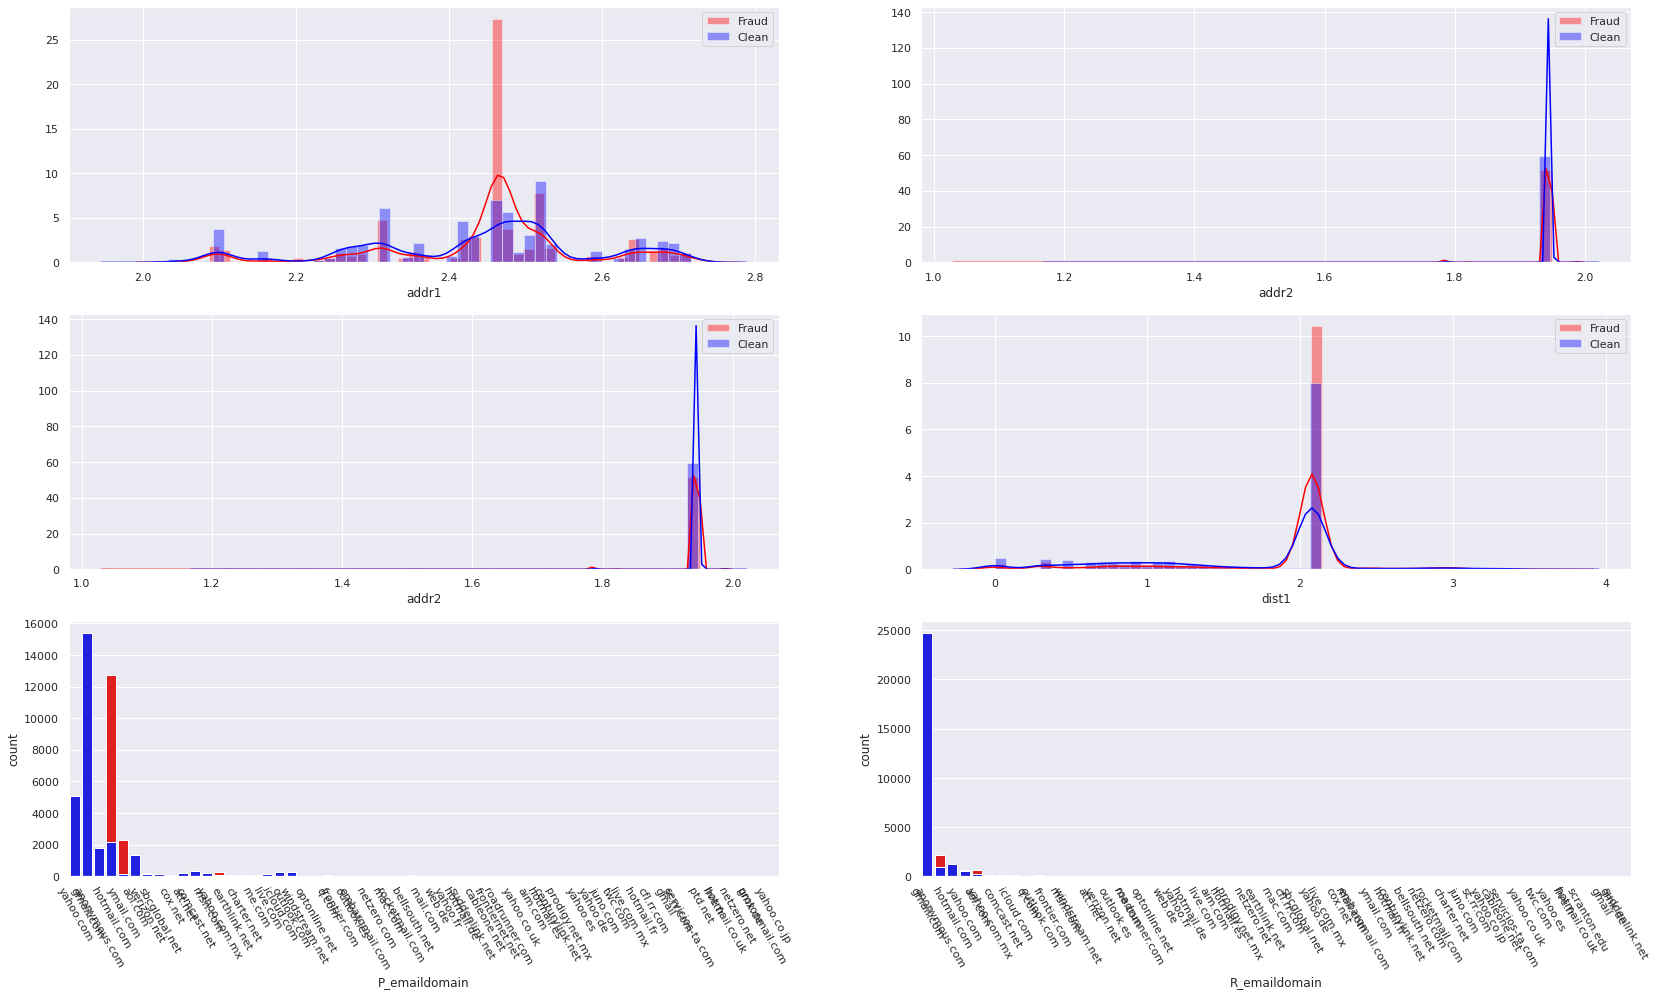

In [207]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(28,16))

features = ['addr1', 'addr2', 'dist1', 'dist2']
for row in range(0, 2):
    for col in range(0, 2):
        sns.distplot(numpy.log10(G_p[features[row+col]].add(1)), color='red', ax=ax[row,col], label='Fraud')
        sns.distplot(numpy.log10(G_n[features[row+col]].add(1)), color='blue', ax=ax[row,col], label='Clean')
        ax[row,col].legend()
        
sns.countplot(G_p['P_emaildomain'], color='red', ax=ax[2, 0], label='Fraud')
sns.countplot(G_n['P_emaildomain'], color='blue', ax=ax[2, 0], label='Clean')
sns.countplot(G_p['R_emaildomain'], color='red', ax=ax[2, 1], label='Fraud')
sns.countplot(G_n['R_emaildomain'], color='blue', ax=ax[2, 1], label='Clean')
ax[2,1].tick_params(axis='x', labelrotation=300)
ax[2,0].tick_params(axis='x', labelrotation=300)
plt.show()

In [212]:
G = pandas.concat([G_p, G_n])

In [219]:
G.head()

,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain
TransactionID,,,,,,
2987203,251.000000,87.00000,118.50218,231.855423,aol.com,gmail.com
2987240,290.733794,86.80063,118.50218,231.855423,hotmail.com,hotmail.com
2987243,290.733794,86.80063,118.50218,231.855423,hotmail.com,hotmail.com
2987245,290.733794,86.80063,118.50218,231.855423,hotmail.com,hotmail.com
2987288,290.733794,86.80063,118.50218,231.855423,outlook.com,outlook.com


In [216]:
tester = Hypot()
G_ = G.copy()
G_[['P_emaildomain', 'R_emaildomain']] = G_[['P_emaildomain', 'R_emaildomain']].apply(LabelEncoder().fit_transform)
mapping = {'addr1': 'cont', 'addr2': 'cont', 'dist1': 'cont', 'dist2': 'cont', 'P_emaildomain': 'cat', 'R_emaildomain': 'cat'}

p = tester.test(data=G_, mapping=mapping)

In [217]:
p

,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain
addr1,1.00000,0.04753,0.30110,0.60686,0.0000,0.14914
addr2,0.04753,1.00000,0.59328,0.00742,0.0000,0.00000
dist1,0.30110,0.59328,1.00000,0.95899,0.0313,1.00000
dist2,0.60686,0.00742,0.95899,1.00000,0.0000,0.00000
P_emaildomain,0.00000,0.00000,0.03130,0.00000,1.0000,0.00000
R_emaildomain,0.14914,0.00000,1.00000,0.00000,0.0000,1.00000


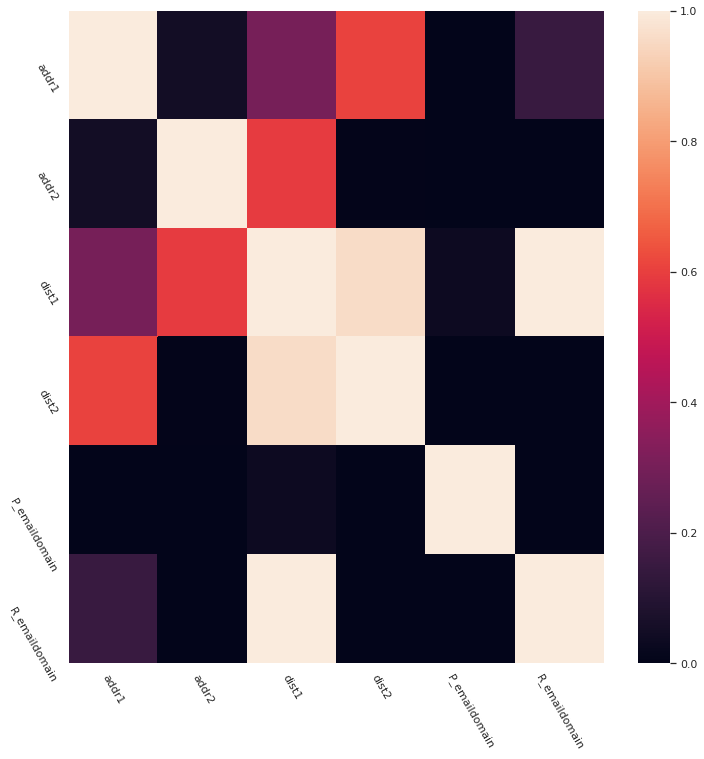

In [218]:
plt.figure(figsize=(12,12))
sns.heatmap(data=p, vmin=0, vmax=1)
plt.yticks(rotation=300)
plt.xticks(rotation=300)
plt.show()

In [220]:
XCG = XC.join(G, how='inner')

In [221]:
XCG.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,C1,C2,...,C11,C12,C13,C14,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000,W,18268,583.0,150.0,visa,226.0,credit,2.0,2.0,...,1.0,0.0,4.0,2.0,251.000000,87.00000,118.50218,231.855423,aol.com,gmail.com
2987240,37.098,C,13413,103.0,185.0,visa,137.0,credit,0.0,1.0,...,1.0,1.0,0.0,0.0,290.733794,86.80063,118.50218,231.855423,hotmail.com,hotmail.com
2987243,37.098,C,13413,103.0,185.0,visa,137.0,credit,1.0,1.0,...,1.0,1.0,0.0,0.0,290.733794,86.80063,118.50218,231.855423,hotmail.com,hotmail.com
2987245,37.098,C,13413,103.0,185.0,visa,137.0,credit,2.0,1.0,...,1.0,1.0,0.0,0.0,290.733794,86.80063,118.50218,231.855423,hotmail.com,hotmail.com
2987288,155.521,C,16578,545.0,185.0,visa,226.0,credit,1.0,1.0,...,1.0,1.0,0.0,0.0,290.733794,86.80063,118.50218,231.855423,outlook.com,outlook.com


In [226]:
X_ = XCG.copy()

In [227]:
X_[['TransactionAmt', 'card1', 'card2', 'card3', 'card5']] = numpy.log10(X_[['TransactionAmt', 'card1', 'card2', 'card3', 'card5']])
X_[[f'C{i}' for i in range(1, 15)]] = numpy.log10(X_[[f'C{i}' for i in range(1, 15)]].add(1))
X_[['card4', 'card6', 'ProductCD', 'P_emaildomain', 'R_emaildomain']] = X_[['card4', 'card6', 'ProductCD', 'P_emaildomain', 'R_emaildomain']].apply(LabelEncoder().fit_transform)

In [228]:
X_.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,C1,C2,...,C11,C12,C13,C14,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,2.648360,4,4.261691,2.765669,2.176091,3,2.354108,1,0.477121,0.477121,...,0.30103,0.00000,0.69897,0.477121,251.000000,87.00000,118.50218,231.855423,2,15
2987240,1.569350,0,4.127526,2.012837,2.267172,3,2.136721,1,0.000000,0.301030,...,0.30103,0.30103,0.00000,0.000000,290.733794,86.80063,118.50218,231.855423,19,18
2987243,1.569350,0,4.127526,2.012837,2.267172,3,2.136721,1,0.301030,0.301030,...,0.30103,0.30103,0.00000,0.000000,290.733794,86.80063,118.50218,231.855423,19,18
2987245,1.569350,0,4.127526,2.012837,2.267172,3,2.136721,1,0.477121,0.301030,...,0.30103,0.30103,0.00000,0.000000,290.733794,86.80063,118.50218,231.855423,19,18
2987288,2.191789,0,4.219532,2.736397,2.267172,3,2.354108,1,0.301030,0.301030,...,0.30103,0.30103,0.00000,0.000000,290.733794,86.80063,118.50218,231.855423,35,34


In [229]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output = model.fit(X_, y)

In [230]:
scores = output.get_booster().get_score(importance_type="gain")

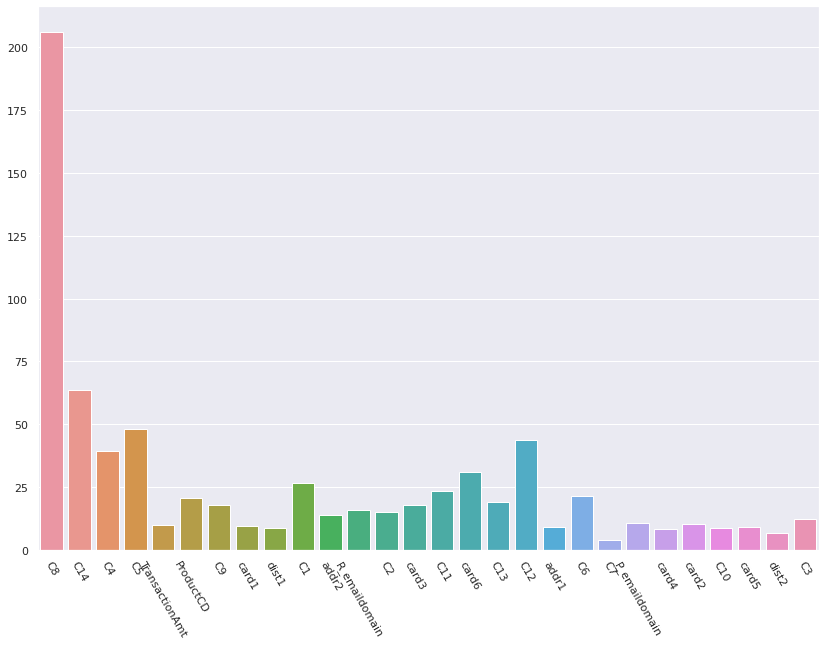

In [231]:
plt.figure(figsize=(14,10))
sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.xticks(rotation=300)
plt.show()

In [232]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_cg = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.8796, recall: 0.7779, f1: 0.8257, aucPR: 0.9191, aucROC: 0.9320
precision: 0.8706, recall: 0.7944, f1: 0.8308, aucPR: 0.9201, aucROC: 0.9288
precision: 0.8822, recall: 0.7823, f1: 0.8292, aucPR: 0.9311, aucROC: 0.9406
precision: 0.8796, recall: 0.7953, f1: 0.8353, aucPR: 0.9272, aucROC: 0.9396
precision: 0.8528, recall: 0.7880, f1: 0.8191, aucPR: 0.9162, aucROC: 0.9312
precision: 0.8691, recall: 0.7904, f1: 0.8279, aucPR: 0.9192, aucROC: 0.9292
precision: 0.8777, recall: 0.7817, f1: 0.8269, aucPR: 0.9240, aucROC: 0.9326
precision: 0.8815, recall: 0.7846, f1: 0.8302, aucPR: 0.9248, aucROC: 0.9349
precision: 0.8848, recall: 0.7841, f1: 0.8314, aucPR: 0.9253, aucROC: 0.9364
precision: 0.8647, recall: 0.7701, f1: 0.8146, aucPR: 0.9154, aucROC: 0.9271
Final - precision: 0.8742, recall: 0.7849, f1: 0.8271, aucPR: 0.9222, aucROC: 0.9332


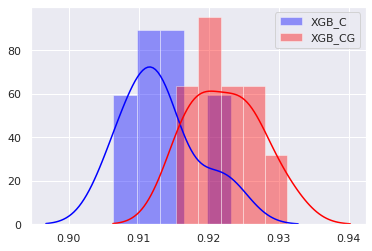

In [233]:
plt.figure()
sns.distplot(xgb_c.aucs, color='blue', bins=5, label='XGB_C')
sns.distplot(xgb_cg.aucs, color='red', bins=5, label='XGB_CG')
plt.legend()

In [234]:
ttest_rel(xgb_cg.aucs, xgb_c.aucs)

Ttest_relResult(statistic=10.538031483722284, pvalue=2.3094482978393737e-06)

### M features

In [280]:
features = [f'M{i}' for i in range(1,10)]

In [281]:
M_family = data.loc[:, features]

In [282]:
M_family.head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
TransactionID,,,,,,,,,
2987000,T,T,T,M2,F,T,NaN,NaN,NaN
2987001,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2987002,T,T,T,M0,F,F,F,F,F
2987003,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
2987004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [283]:
mode_imp = SimpleImputer(strategy='most_frequent')

In [284]:
M_family = mode_imp.fit_transform(M_family)

In [285]:
M_family.head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
TransactionID,,,,,,,,,
2987000,T,T,T,M2,F,T,F,F,T
2987001,T,T,T,M0,T,T,F,F,T
2987002,T,T,T,M0,F,F,F,F,F
2987003,T,T,T,M0,T,F,F,F,T
2987004,T,T,T,M0,F,F,F,F,T


In [286]:
M_pos = M_family.loc[y_pos.index, :]
M_neg = M_family.loc[y_neg.index, :]

In [287]:
M_p = compute(M_pos)[0]
M_n = compute(M_neg)[0]

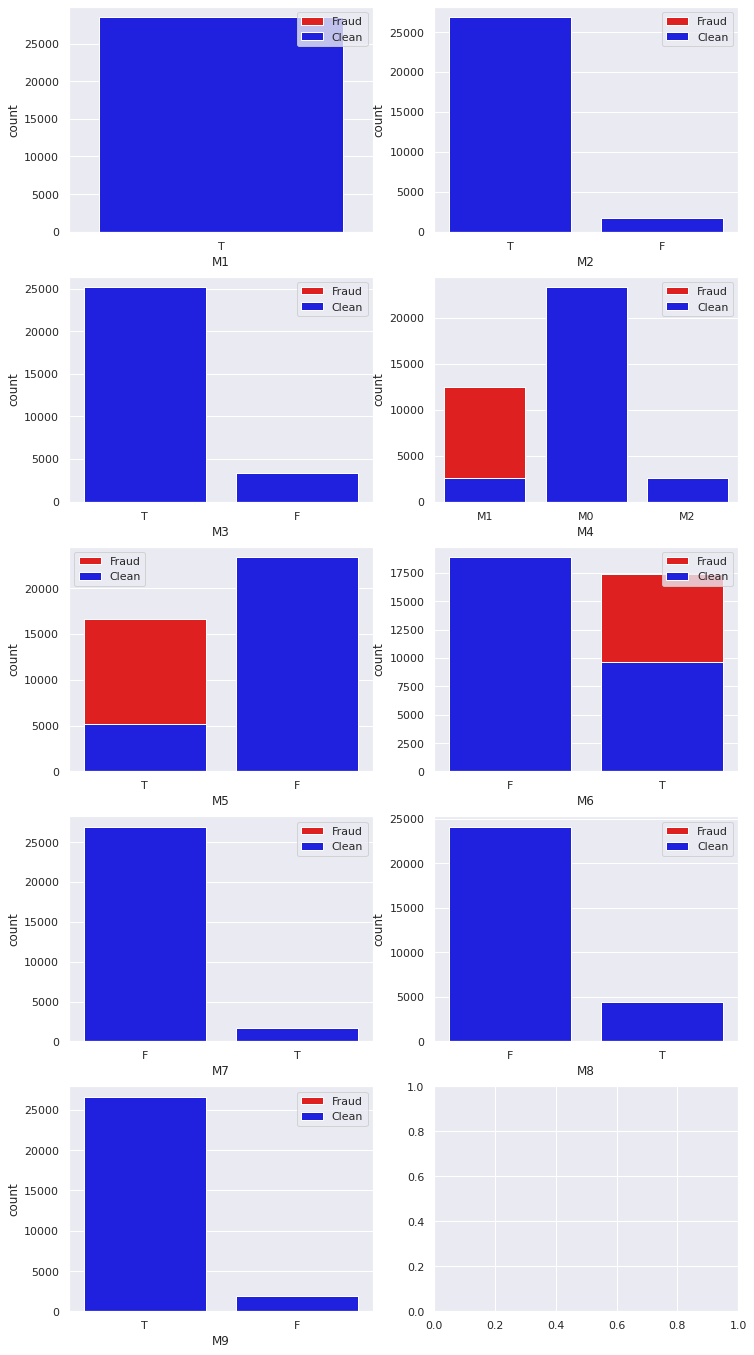

In [288]:
f, ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 24))

feature = 1
for row in range(0, 5):
    for col in range(0, 2):
        if feature < 10:
            sns.countplot(M_p[f'M{feature}'], color='red', ax=ax[row,col], label='Fraud')
            sns.countplot(M_n[f'M{feature}'], color='blue', ax=ax[row,col], label='Clean')
            ax[row,col].legend()
            feature += 1


In [290]:
M = pandas.concat([M_p, M_n])

In [294]:
M.head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
TransactionID,,,,,,,,,
2987203,T,T,T,M0,F,T,F,F,T
2987240,T,T,T,M2,F,F,F,F,T
2987243,T,T,T,M2,F,F,F,F,T
2987245,T,T,T,M2,F,F,F,F,T
2987288,T,T,T,M2,F,F,F,F,T


In [291]:
tester = Hypot()
M_ = M.copy()
M_[features] = M_[features].apply(LabelEncoder().fit_transform)
mapping = {f: 'cat' for f in features}

p = tester.test(data=M_, mapping=mapping)

In [296]:
p

,M1,M2,M3,M4,M5,M6,M7,M8,M9
M1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M2,NaN,1.00000,0.00000,0.0,0.00241,0.00107,0.08581,0.04931,0.00000
M3,NaN,0.00000,1.00000,0.0,0.00000,0.00000,0.10443,0.00004,0.00000
M4,NaN,0.00000,0.00000,1.0,0.00000,0.00000,0.00000,0.00000,0.00000
M5,NaN,0.00241,0.00000,0.0,1.00000,0.00000,0.00000,0.00000,0.00321
M6,NaN,0.00107,0.00000,0.0,0.00000,1.00000,0.00000,0.00000,0.00000
M7,NaN,0.08581,0.10443,0.0,0.00000,0.00000,1.00000,0.00000,0.00000
M8,NaN,0.04931,0.00004,0.0,0.00000,0.00000,0.00000,1.00000,0.00000
M9,NaN,0.00000,0.00000,0.0,0.00321,0.00000,0.00000,0.00000,1.00000


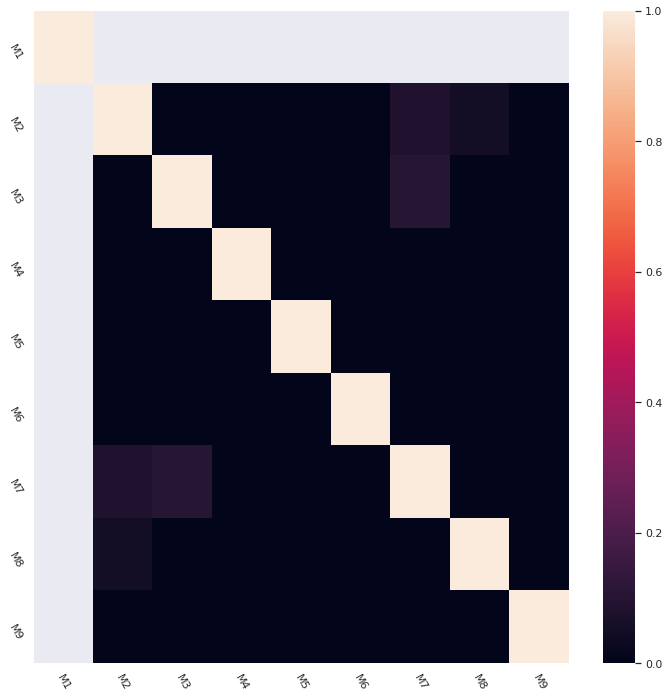

In [293]:
plt.figure(figsize=(12,12))
sns.heatmap(data=p, vmin=0, vmax=1)
plt.yticks(rotation=300)
plt.xticks(rotation=300)
plt.show()

In [298]:
XCGM = XCG.join(M, how='inner')

In [299]:
XCGM.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,C1,C2,...,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,445.000,W,18268,583.0,150.0,visa,226.0,credit,2.0,2.0,...,gmail.com,T,T,T,M0,F,T,F,F,T
2987240,37.098,C,13413,103.0,185.0,visa,137.0,credit,0.0,1.0,...,hotmail.com,T,T,T,M2,F,F,F,F,T
2987243,37.098,C,13413,103.0,185.0,visa,137.0,credit,1.0,1.0,...,hotmail.com,T,T,T,M2,F,F,F,F,T
2987245,37.098,C,13413,103.0,185.0,visa,137.0,credit,2.0,1.0,...,hotmail.com,T,T,T,M2,F,F,F,F,T
2987288,155.521,C,16578,545.0,185.0,visa,226.0,credit,1.0,1.0,...,outlook.com,T,T,T,M2,F,F,F,F,T


In [300]:
X_ = XCGM.copy()

In [301]:
X_[['TransactionAmt', 'card1', 'card2', 'card3', 'card5']] = numpy.log10(X_[['TransactionAmt', 'card1', 'card2', 'card3', 'card5']])
X_[[f'C{i}' for i in range(1, 15)]] = numpy.log10(X_[[f'C{i}' for i in range(1, 15)]].add(1))
X_[['card4', 'card6', 'ProductCD', 'P_emaildomain', 'R_emaildomain']] = X_[['card4', 'card6', 'ProductCD', 'P_emaildomain', 'R_emaildomain']].apply(LabelEncoder().fit_transform)
X_[features] = X_[features].apply(LabelEncoder().fit_transform)

In [302]:
X_.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,C1,C2,...,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987203,2.648360,4,4.261691,2.765669,2.176091,3,2.354108,1,0.477121,0.477121,...,15,0,1,1,0,0,1,0,0,1
2987240,1.569350,0,4.127526,2.012837,2.267172,3,2.136721,1,0.000000,0.301030,...,18,0,1,1,2,0,0,0,0,1
2987243,1.569350,0,4.127526,2.012837,2.267172,3,2.136721,1,0.301030,0.301030,...,18,0,1,1,2,0,0,0,0,1
2987245,1.569350,0,4.127526,2.012837,2.267172,3,2.136721,1,0.477121,0.301030,...,18,0,1,1,2,0,0,0,0,1
2987288,2.191789,0,4.219532,2.736397,2.267172,3,2.354108,1,0.301030,0.301030,...,34,0,1,1,2,0,0,0,0,1


In [303]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
output = model.fit(X_, y)

In [304]:
scores = output.get_booster().get_score(importance_type="gain")

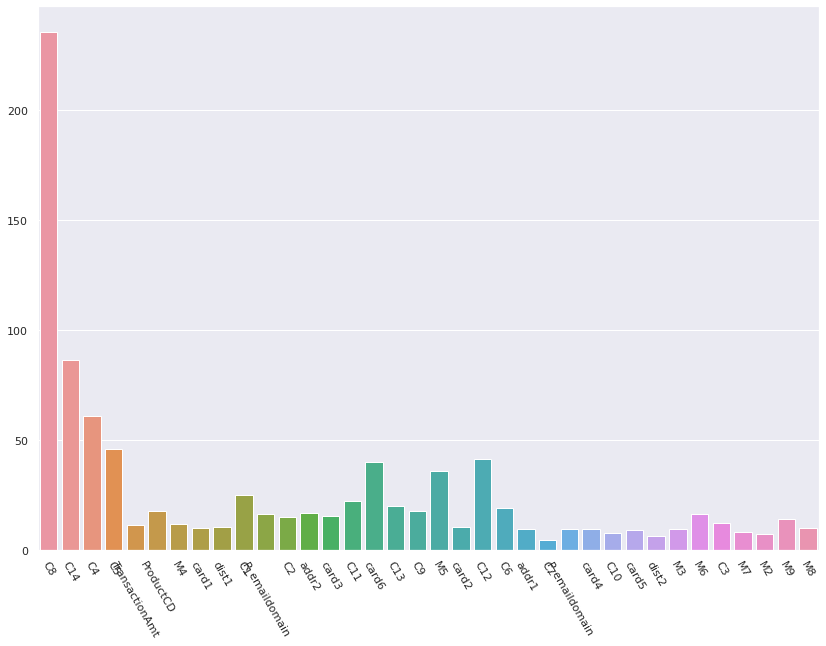

In [305]:
plt.figure(figsize=(14,10))
sns.barplot(x=list(scores.keys()), y=list(scores.values()))
plt.xticks(rotation=300)
plt.show()

In [306]:
model = XGBClassifier(random_state=SEED, n_jobs=JOBS)
xgb_cgm = ml_pipeline(X=X_, y=y, n_splits=10, model=model)

precision: 0.8753, recall: 0.7876, f1: 0.8291, aucPR: 0.9222, aucROC: 0.9335
precision: 0.8734, recall: 0.8041, f1: 0.8373, aucPR: 0.9243, aucROC: 0.9343
precision: 0.8840, recall: 0.8041, f1: 0.8422, aucPR: 0.9306, aucROC: 0.9407
precision: 0.8782, recall: 0.8132, f1: 0.8444, aucPR: 0.9334, aucROC: 0.9450
precision: 0.8551, recall: 0.8025, f1: 0.8280, aucPR: 0.9190, aucROC: 0.9326
precision: 0.8708, recall: 0.7996, f1: 0.8337, aucPR: 0.9216, aucROC: 0.9335
precision: 0.8804, recall: 0.7836, f1: 0.8292, aucPR: 0.9236, aucROC: 0.9333
precision: 0.8814, recall: 0.7914, f1: 0.8340, aucPR: 0.9281, aucROC: 0.9384
precision: 0.8866, recall: 0.7948, f1: 0.8382, aucPR: 0.9264, aucROC: 0.9385
precision: 0.8671, recall: 0.7865, f1: 0.8249, aucPR: 0.9221, aucROC: 0.9318
Final - precision: 0.8752, recall: 0.7967, f1: 0.8341, aucPR: 0.9251, aucROC: 0.9362


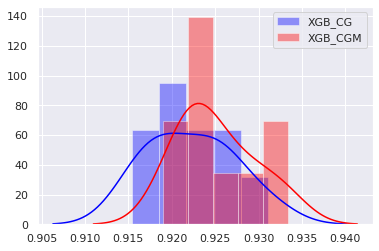

In [308]:
plt.figure()
sns.distplot(xgb_cg.aucs, color='blue', bins=5, label='XGB_CG')
sns.distplot(xgb_cgm.aucs, color='red', bins=5, label='XGB_CGM')
plt.legend()

In [309]:
ttest_rel(xgb_cgm.aucs, xgb_cg.aucs)

Ttest_relResult(statistic=3.783326643854427, pvalue=0.004326819604076084)

### D features